# Prenatal care and NICU admission

Exploring relationships between prenatal care, admission to the NICU, and gestational age

In [62]:
import warnings

import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.api as sm

warnings.filterwarnings('ignore')
my_cmap = cm.get_cmap('tab10')

In [63]:
def filter_values(row):
    if row.isna().any():
        return True
    if 'Unreliable' in row[['Births', 'NICU Admission Code']]:
        return True
    if 'Not Applicable' in row[['Births', 'NICU Admission Code']]:
        return True
    if float(row['Births']) == 0.0:
        return True
    return False

def get_prenatal(row):
    return row['Month Prenatal Care Began Code'] != 0

prenatal = pd.read_csv('../data/CDC/prenatal_nicu.txt', sep='\t')
prenatal.drop(columns=['Notes', 'Year Code'], inplace=True)
prenatal['Drop'] = prenatal.apply(filter_values, axis=1)
prenatal = prenatal[prenatal['Drop'] == False].drop(columns='Drop')
prenatal['Prenatal Care'] = prenatal.apply(get_prenatal, axis=1)
prenatal['NICU Admission Code'] = prenatal.apply(lambda row: int(row['NICU Admission Code'] == 1), axis=1)
prenatal = prenatal.astype({
    'Month Prenatal Care Began Code': int,
    'Year': int,
    'OE Gestational Age Weekly Code': int,
    'NICU Admission Code': int,
    'Births': int
})

subset = prenatal[(prenatal['OE Gestational Age Weekly Code'] >= 28) &
                  (prenatal['OE Gestational Age Weekly Code'] <= 40)]

## Is there a difference between Apgar score with or without prenatal care?

In [70]:
sub

,Month Prenatal Care Began,Month Prenatal Care Began Code,OE Gestational Age Weekly,OE Gestational Age Weekly Code,NICU Admission,NICU Admission Code,Year,Births,Prenatal Care
598,1st month,1,40 weeks,40,Yes,1,2019,1177,True
603,1st month,1,40 weeks,40,No,0,2019,28747,True
940,2nd month,2,40 weeks,40,Yes,1,2019,9844,True
945,2nd month,2,40 weeks,40,No,0,2019,255722,True
1282,3rd month,3,40 weeks,40,Yes,1,2019,8216,True
1287,3rd month,3,40 weeks,40,No,0,2019,222441,True
1624,4th month,4,40 weeks,40,Yes,1,2019,2460,True
1629,4th month,4,40 weeks,40,No,0,2019,63262,True
1966,5th month,5,40 weeks,40,Yes,1,2019,1294,True
1971,5th month,5,40 weeks,40,No,0,2019,30463,True


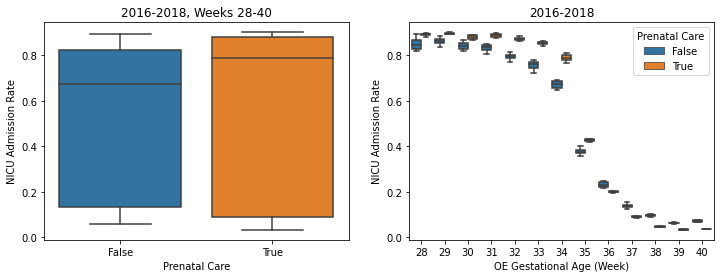

In [73]:
year_list = []
week_list = []
care_list = []
rate_list = []
for year in subset['Year'].unique():
    for week in subset['OE Gestational Age Weekly Code'].unique():
        for care in subset['Prenatal Care'].unique():
            sub = subset[(subset['Year'] == year) &
                         (subset['OE Gestational Age Weekly Code'] == week) &
                         (subset['Prenatal Care'] == care)]
            births = sub['Births']
            nicu = sub['NICU Admission Code']
            nicu_rate = (births*nicu).sum()/births.sum()
            year_list.append(year)
            week_list.append(week)
            care_list.append(care)
            rate_list.append(nicu_rate)
df2 = pd.DataFrame(data={
    'Year': year_list,
    'Gestational Week': week_list,
    'Prenatal Care': care_list,
    'NICU Admission Rate': rate_list
})

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x='Prenatal Care', y='NICU Admission Rate', data=df2, ax=ax[0])
ax[0].set_title('2016-2018, Weeks 28-40')

sns.boxplot(x='Gestational Week', y='NICU Admission Rate', hue='Prenatal Care', data=df2, ax=ax[1])
ax[1].set_xlabel('OE Gestational Age (Week)')
ax[1].set_title('2016-2018');

In [74]:
care = df2[df2['Prenatal Care'] == True]
nocare = df2[df2['Prenatal Care'] == False]
print('00', ttest_ind(care['NICU Admission Rate'], nocare['NICU Admission Rate'], equal_var=False))

for week in df2['Gestational Week'].unique():
    care_sub = care[care['Gestational Week'] == week]
    nocare_sub = nocare[nocare['Gestational Week'] == week]
    print(week, ttest_ind(care_sub['NICU Admission Rate'],
                          nocare_sub['NICU Admission Rate'], equal_var=False))

00 Ttest_indResult(statistic=0.3490474702238628, pvalue=0.7277848813194943)
28 Ttest_indResult(statistic=2.3871078362079263, pvalue=0.08912589082177251)
29 Ttest_indResult(statistic=3.2833337810986594, pvalue=0.040338396697980665)
30 Ttest_indResult(statistic=3.2122006982991147, pvalue=0.029984145765779156)
31 Ttest_indResult(statistic=4.891515278811442, pvalue=0.006207475747926728)
32 Ttest_indResult(statistic=7.461897775117262, pvalue=0.0011096723287364258)
33 Ttest_indResult(statistic=7.347163163474115, pvalue=0.0023337367823890146)
34 Ttest_indResult(statistic=8.479271844782156, pvalue=0.00016020614954947171)
35 Ttest_indResult(statistic=5.358830567237748, pvalue=0.0078041060792866076)
36 Ttest_indResult(statistic=-4.122779282116917, pvalue=0.021888905971627404)
37 Ttest_indResult(statistic=-7.645368934032786, pvalue=0.0030439614761738677)
38 Ttest_indResult(statistic=-16.721399886330065, pvalue=0.0003079390032046217)
39 Ttest_indResult(statistic=-15.591996581375456, pvalue=0.00026

In [44]:
# Can we fit a model to the data by gestational week?
# Can someone interpret the model summaries?
# What about fitting a sigmoid?

In [75]:
df_t = df2[df2['Prenatal Care'] == True]
model_t = sm.OLS(df_t['NICU Admission Rate'], sm.add_constant(df_t['Gestational Week']))
res_t = model_t.fit()
print(res_f.summary())

                             OLS Regression Results                            
Dep. Variable:     NICU Admission Code   R-squared:                       0.898
Model:                             OLS   Adj. R-squared:                  0.896
Method:                  Least Squares   F-statistic:                     438.4
Date:                 Sun, 17 Oct 2021   Prob (F-statistic):           2.12e-26
Time:                         23:27:58   Log-Likelihood:                 43.007
No. Observations:                   52   AIC:                            -82.01
Df Residuals:                       50   BIC:                            -78.11
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.3544   

In [76]:
df_f = df2[df2['Prenatal Care'] == False]
model_f = sm.OLS(df_f['NICU Admission Rate'], sm.add_constant(df_f['Gestational Week']))
res_f = model_f.fit()
print(res_f.summary())

                             OLS Regression Results                            
Dep. Variable:     NICU Admission Rate   R-squared:                       0.898
Model:                             OLS   Adj. R-squared:                  0.896
Method:                  Least Squares   F-statistic:                     438.4
Date:                 Sun, 17 Oct 2021   Prob (F-statistic):           2.12e-26
Time:                         23:28:01   Log-Likelihood:                 43.007
No. Observations:                   52   AIC:                            -82.01
Df Residuals:                       50   BIC:                            -78.11
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.3544   

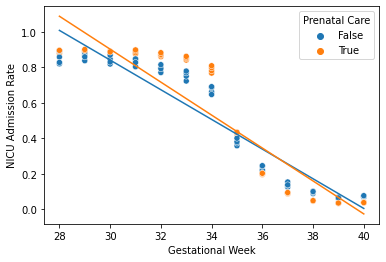

In [77]:
fig, ax = plt.subplots()
sns.scatterplot(x='Gestational Week', y='NICU Admission Rate', hue='Prenatal Care', data=df2, ax=ax)

x = np.linspace(28, 40)
y_f = np.polyval([res_f.params[1], res_f.params[0]], x)
ax.plot(x, y_f)

y_t = np.polyval([res_t.params[1], res_t.params[0]], x)
ax.plot(x, y_t);

In [9]:
# Maybe a different type of curve? Sigmoid?

## Does the month you start prenatal care matter?

In [78]:
# Linear model
year_list = []
week_list = []
month_list = []
rate_list = []
for year in subset['Year'].unique():
    for week in subset['OE Gestational Age Weekly Code'].unique():
        for month in subset['Month Prenatal Care Began Code'].unique():
            sub = subset[(subset['Year'] == year) &
                         (subset['OE Gestational Age Weekly Code'] == week) &
                         (subset['Month Prenatal Care Began Code'] == month) &
                         (subset['Prenatal Care'] == True)]
            births = sub['Births']
            nicu = sub['NICU Admission Code']
            nicu_rate = (births*nicu).sum()/births.sum()
            year_list.append(year)
            week_list.append(week)
            month_list.append(month)
            rate_list.append(nicu_rate)
df = pd.DataFrame(data={
    'Year': year_list,
    'Gestational Week': week_list,
    'Month Care Began': month_list,
    'NICU Admission Rate': rate_list,
})
df = df[df['NICU Admission Rate'].isna() == False]
model_ls = sm.OLS(df['NICU Admission Rate'], sm.add_constant(df[['Gestational Week', 'Month Care Began']]))
res_ls = model_ls.fit()
print(res_ls.summary())

                             OLS Regression Results                            
Dep. Variable:     NICU Admission Rate   R-squared:                       0.860
Model:                             OLS   Adj. R-squared:                  0.860
Method:                  Least Squares   F-statistic:                     1285.
Date:                 Sun, 17 Oct 2021   Prob (F-statistic):          5.23e-179
Time:                         23:29:15   Log-Likelihood:                 233.97
No. Observations:                  420   AIC:                            -461.9
Df Residuals:                      417   BIC:                            -449.8
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.6775   

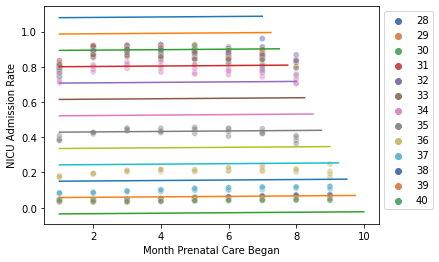

In [82]:
fig, ax = plt.subplots()
sns.scatterplot(x='Month Care Began', y='NICU Admission Rate', hue='Gestational Week',
                palette='deep', data=df, ax=ax, alpha=0.5)

for week in df['Gestational Week'].unique():
    x = np.linspace(1, week/4)
    y = res_ls.params[0] + res_ls.params[1]*week + res_ls.params[2]*x
    ax.plot(x, y)
    
ax.set_xlabel('Month Prenatal Care Began')
ax.legend(bbox_to_anchor=(1, 1));

# Looks terrible

In [83]:
# Mixed-effects model
model_me = sm.MixedLM(df['NICU Admission Rate'].values,  # dependent variable
                      df['Month Care Began'].values, # fixed effects covariates
                      df['Gestational Week'].values) # groups
res_me = model_me.fit()
print(res_me.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y       
No. Observations: 420     Method:             REML    
No. Groups:       13      Scale:              0.0008  
Min. group size:  28      Log-Likelihood:     826.1917
Max. group size:  36      Converged:          Yes     
Mean group size:  32.3                                
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
x1            0.002    0.001 4.015 0.000  0.001  0.004
Group Var     0.400    5.511                          



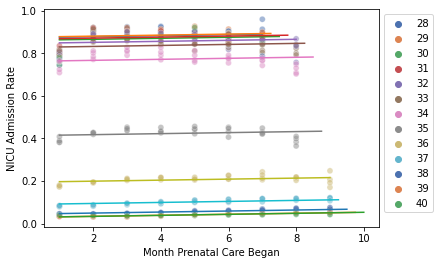

In [84]:
fig, ax = plt.subplots()
sns.scatterplot(x='Month Care Began', y='NICU Admission Rate', hue='Gestational Week',
                palette='deep', data=df, ax=ax, alpha=0.5)

for week in df['Gestational Week'].unique():
    x = np.linspace(1, week/4)
    y = res_me.random_effects[week][0] + res_me.params[0]*x
    ax.plot(x, y)
    
ax.set_xlabel('Month Prenatal Care Began')
ax.legend(bbox_to_anchor=(1, 1));

In [14]:
# Is there a way to keep a linear model, but have random slopes and intercepts?
# Is any of this useful?

# Look at sigmoid!